In [1]:
import json
import yaml
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))

from Gyrus import Gyrus

def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
sensor_log,first_timestamp=load_sensor_log_file("../to_study/initial_chase_calib.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../to_study/track_stop_sign.txt")

In [2]:
from Gyrus import ThreadedGyrus
from NNCalibration import StatePredictor
import torch
import torch.nn as nn

class VisualMotionCalibGyrus(ThreadedGyrus):
    def __init__(self,broker):
        
        self.motionpredictor=nn.Sequential(nn.Linear(4,4),
                              nn.Tanh(),
                              nn.Linear(4,1))
        decision_bounds=[ [-0.8,0.8], [-0.8,0.8], [0.1,0.5]] 
        self.state_predictor=StatePredictor(self.motionpredictor,decision_bounds=decision_bounds)
        
        #constants
        self.min_update_interval=0.1 #don't record experiences more than this often     
        self.objects_to_watch=["sports ball","stop sign","chair"]
        self.fresh_memories_to_train=16

        #scales of things
        self.position_scale=640
        
        #temporary storage
        self.last_unique_objects={}
        self.last_gyro_z=[0,0] #value, stdev
        self.last_motors_active=[1,1] #left, right
        self.last_frame_motion_command=[0,0,0] #left,right, duration
        self.next_update_time=0

        #debugging storage
        self.all_input_vectors=[]
        self.all_target_vectors=[]
        self.all_decision_vectors=[]

        super().__init__(broker)
        
    def get_keys(self):
        return [ "drive/motors_active","position_sensor/gyro", "tagged_objects", "motor_command", "clock_pulse" ]

    def get_name(self):
        return "VisualMotionCalibGyrus"

    def holding_still(self,timestamp): #return true if I think I'm holding still
        if abs(self.last_gyro_z[0])> 0.05 or abs(self.last_gyro_z[0])>0.05:
            return False
        if self.last_motors_active[0]!=0 or self.last_motors_active[1]!=0:
            return False
        if timestamp<self.next_update_time:
            return False
        return True
    
    def get_unique_tagged_objects(self,tagged_objects):
        ret={}
        label_list=[ x["label"] for x in tagged_objects]
        for key in self.objects_to_watch:
            if label_list.count(key)>1 or label_list.count(key)==0:
                continue
            elem=next(filter(lambda x: x["label"]==key,tagged_objects))
            ret[key]=elem
        return ret
            
    
    def read_message(self,message):
        
        if "clock_pulse" in message:
            #don't think about training if not holding still
            if not self.holding_still(message["timestamp"]):
                return 
            if self.state_predictor.fresh_memories>self.fresh_memories_to_train:
                self.state_predictor.train()
                print("training")
            
        if "position_sensor/gyro" in message:
            gyro_z=message["position_sensor/gyro"][2]
            gyro_z_stdev=message["position_sensor/gyro_stdev"][2]
            self.last_gyro_z=[gyro_z,gyro_z_stdev]
        if "drive/motors_active" in message:
            left_motor=message["drive/motors_active"][0]
            right_motor=message["drive/motors_active"][1]
            self.last_motors_active=[left_motor,right_motor]
        if "motor_command" in message:
            m=message["motor_command"]
            if m["lr_throttle"][0] or m["lr_throttle"][1]!=0:
                #self.last_motion_time=message["timestamp"]
                self.last_frame_motion_command=[ m["lr_throttle"][0],m["lr_throttle"][1],m["duration"]]
                self.next_update_time=message["timestamp"]+m["duration"]
        if "tagged_objects" in message:
            #only check if holding still
            if not self.holding_still(message["timestamp"]):
                return 
            unique_objects=self.get_unique_tagged_objects(message["tagged_objects"])
            for key in unique_objects:
                if key in self.last_unique_objects:
                    #exists in both this and last set
                    
                    #get 'center of mass' x f
                    prev_startx=self.last_unique_objects[key]["startx"]
                    prev_endx=self.last_unique_objects[key]["endx"]
                    prev_x=0.5*(prev_startx+prev_endx)
                    next_startx=unique_objects[key]["startx"]
                    next_endx=unique_objects[key]["endx"]
                    next_x=0.5*(next_startx+next_endx)
                    
                    last_input_vector=[prev_x/self.position_scale]
                    target_vector=[next_x/self.position_scale]
                    self.state_predictor.observe(last_input_vector,self.last_frame_motion_command,target_vector)
                    self.all_input_vectors.append(last_input_vector)
                    self.all_decision_vectors.append(self.last_frame_motion_command)
                    self.all_target_vectors.append(target_vector)
            self.last_unique_objects=unique_objects
            self.last_frame_motion_command=[0,0,0]
            self.next_update_time=message["timestamp"]+self.min_update_interval
            
from tqdm import tqdm
import time
vmgyrus=VisualMotionCalibGyrus(None)
for message in tqdm(sensor_log):
    vmgyrus.read_message(message)
    vmgyrus.read_message({"timestamp": time.time(),"clock_pulse": 0.1})

  4%|██▊                                                                          | 142/3957 [00:00<00:03, 1256.84it/s]

training
training
training


 11%|████████▋                                                                     | 439/3957 [00:00<00:03, 911.83it/s]

training
training
training


 15%|███████████▋                                                                  | 590/3957 [00:00<00:03, 859.87it/s]

training
training
training


 23%|█████████████████▌                                                            | 891/3957 [00:00<00:03, 905.48it/s]

training
training
training


 26%|████████████████████▎                                                        | 1045/3957 [00:01<00:03, 900.81it/s]

training
training
training

 33%|█████████████████████████▏                                                   | 1296/3957 [00:01<00:02, 902.74it/s]


training
training


 50%|█████████████████████████████████████▉                                      | 1977/3957 [00:01<00:01, 1757.62it/s]

training
training


 66%|█████████████████████████████████████████████████▊                          | 2596/3957 [00:01<00:00, 2254.23it/s]

training
training
training


 79%|████████████████████████████████████████████████████████████▎               | 3143/3957 [00:02<00:00, 2531.88it/s]

training
training
training

100%|████████████████████████████████████████████████████████████████████████████| 3957/3957 [00:02<00:00, 1717.91it/s]


training


In [3]:
print(len(vmgyrus.state_predictor.experience_memory))

64


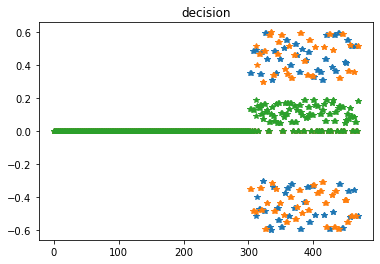

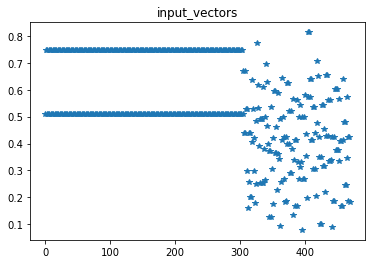

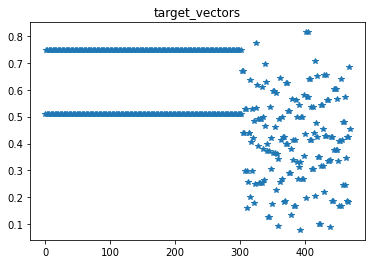

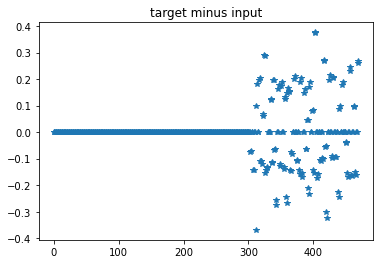

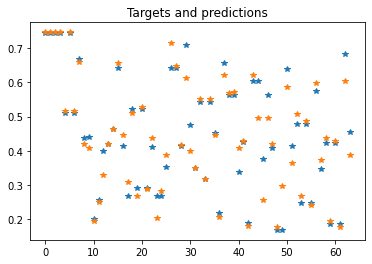

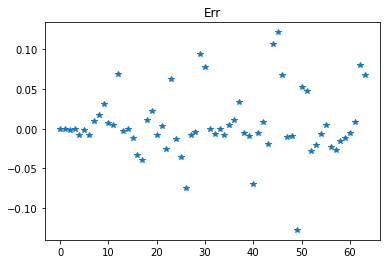

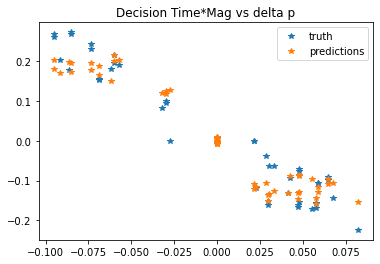

In [5]:
from matplotlib import pyplot as plt
import numpy as np

inputs,targets=vmgyrus.state_predictor.experience_memory.get_as_batches()
out=vmgyrus.state_predictor.predictor( inputs )
out=out.detach().numpy()
inputs=inputs.detach().numpy()
targets=targets.detach().numpy()

all_input_vectors=np.array(vmgyrus.all_input_vectors)
all_decision_vectors=np.array(vmgyrus.all_decision_vectors)
all_target_vectors=np.array(vmgyrus.all_target_vectors)


fig, ax = plt.subplots()
plt.title("decision")
ax.plot( all_decision_vectors,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("input_vectors")
ax.plot( all_input_vectors,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("target_vectors")
ax.plot( all_target_vectors,'*')
plt.show()

fig, ax = plt.subplots()
plt.title("target minus input")
ax.plot( all_target_vectors-all_input_vectors,'*')
plt.show()


fig, ax = plt.subplots()
plt.title("Targets and predictions")
ax.plot( targets[:],'*')
ax.plot( out[:],'*')

plt.show()

fig, ax = plt.subplots()
plt.title("Err")
ax.plot( targets[:,0]-out[:,0],'*')
plt.show()

fig, ax = plt.subplots()
plt.title("Decision Time*Mag vs delta p")
ax.plot( inputs[:,1]*inputs[:,3],targets[:,0]-inputs[:,0],'*',label='truth')
ax.plot( inputs[:,1]*inputs[:,3],out[:,0]-inputs[:,0],'*',label='predictions')
plt.legend()
plt.show()